In [1]:
import pickle
import pandas as pd
import numpy as np
from scipy.io import mmread
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns

import anndata
import scanpy as sc
sc.settings.verbosity = 2 

from tools import kobak_tsne_w_exag, pearson_residuals, highly_variable_residuals
from tools_R import glmpca_R
from contextlib import redirect_stderr


### Cao Preproc

In [2]:
### THIS CELL CAN BE COMMENTED OUT AFTER IT RAN ONCE ###
#~33min

file = 'datasets/cao/gene_count.txt'


cell_meta = pd.read_csv('datasets/cao/cell_annotate.csv')

cells = np.array(cell_meta['sample'])
embryo = np.array(cell_meta['embryo_id'])
cluster = np.array(cell_meta['Main_Cluster'])
cluster_names = np.array(cell_meta['Main_cell_type'])

genes_meta = pd.read_csv('datasets/cao/gene_annotate.csv')

genes = np.array(genes_meta['gene_short_name'])

counts = mmread(file).transpose() 
counts = sparse.csc_matrix(counts)

dataset = dict(counts=counts,
               genes=genes,
               cells=cells,cluster=cluster,cluster_names=cluster_names,embryo=embryo,
               label='Cao 2019 2059k mouse embryo development (sciRNA)',labelshort='sciRNA 2059k mouse embryo \n Cao 2019',folder=file)
picklefile = file + 'preprocessed.pickle'
pickle.dump(dataset, open(picklefile, "wb"), protocol=4)

### Load preproc

In [3]:
with open('datasets/cao/gene_count.txtpreprocessed.pickle','rb') as f:
    data_dict = pickle.load(f)

var = pd.DataFrame(dict(genes=data_dict['genes']))
obs = pd.DataFrame(dict(cells=data_dict['cells'],
                       embryo=data_dict['embryo']))

adata = anndata.AnnData(X=data_dict['counts'], var=var, obs=obs)

adata.var_names_make_unique()

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
# read in cluster labels
clusters = data_dict['cluster'].copy()
clusters[~np.isnan(clusters)] -= 1
clusters[np.isnan(clusters)] = -1
clusters = clusters.astype(int)

# cluster names - "Main cluster" and "Main cell type" contain the same info
cluster_names = data_dict['cluster_names'][np.unique(clusters, return_index=True)[1][1:]].copy()

#set up colors
clusterColors = np.array('''#c886ba #5cbb5e #9751a0 #84b941 #8e6db0 #bbbb3c #5667b0 #e58824 #778cc6 #d6ac3d
#785aa5 #204a87 #36384a #5ec08d #e53e77 #50c1b4 #dd464a #3bbbc6 #d6552c #5baada #cf8a34 #4d62ad
#8b8a34 #a34f9a #9db36b #cb4188 #37825c #b23d4f #5d7131 #b59ac9 #a55725 #5277af #e38f68 #86619d
#caa56a #9c476d #886a2c #dd81a9'''.split())
tab10colors = np.array(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
                             'tab:brown','tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'])
del data_dict

## Gene selection

In [5]:
def gene_selection(adata,n_top_genes = 2000, theta = 100):

    hvg_pearson = highly_variable_residuals(adata,
                                            n_top_genes=n_top_genes,
                                            theta=theta,
                                            chunksize=1000,
                                            inplace=False,
                                            check_values=False,
                                            residual_type='pearson')
    adata.var['hvg_pearson'] = np.array(hvg_pearson['highly_variable'])
    adata.uns['hvg_pearson_df'] = hvg_pearson
    
    hvg_dict = dict(var=adata.var)

    with open('datasets/cao/gene_selection_pearson_%uof%ugenes.pickle'%(n_top_genes,adata.shape[1]),'wb') as f:
        pickle.dump(hvg_dict,f)

In [6]:
n_top_genes = 2000

In [7]:
### THIS CELL CAN BE COMMENTED OUT AFTER IT RAN ONCE ###
### run gene selection (~15min)
gene_selection(adata,n_top_genes=n_top_genes)

In [8]:
# ### load results and subset
with open('datasets/cao/gene_selection_pearson_%uof%ugenes.pickle'%(n_top_genes,adata.shape[1]),'rb') as f:
    hvg_dict = pickle.load(f)

adata_hvg_pearson = adata[:,hvg_dict['var']['hvg_pearson']].copy()

In [9]:
def find_artifact_genes(adata, mincount = 10, cutoff_factor = 100):
    
    embryo_ids = np.unique(adata.obs['embryo'])
    n_cells_with_mincount = np.nan * np.ones((len(embryo_ids),adata.shape[1])) #n_embryos x n_genes
    for i,embryo_id in enumerate(embryo_ids):
        embryo_idx = np.array(adata.obs['embryo'] == embryo_id)    
        X_embryo = adata.X[embryo_idx,:]

        cells_with_mincount = X_embryo > mincount
        n_cells_with_mincount[i,:] = np.squeeze(np.array(np.sum(cells_with_mincount,axis=0)))
    
    #sort by embryo
    n_cells_with_mincount_sorted = np.sort(n_cells_with_mincount,axis=0) 

    n_cells_with_mincount_max = n_cells_with_mincount_sorted[-1,:]
    n_cells_with_mincount_3rdmax = n_cells_with_mincount_sorted[-3,:]
    
    genes_to_remove_idx = (1+n_cells_with_mincount_max/cutoff_factor) > (1 + n_cells_with_mincount_3rdmax)
        
    genes_to_remove = adata_hvg_pearson.var['genes'][genes_to_remove_idx]
    
    with open('datasets/cao/artifact_genes.pickle','wb') as f:
        pickle.dump(list(genes_to_remove),f)

    return n_cells_with_mincount, embryo_ids, dict(n_cells_with_mincount_max=n_cells_with_mincount_max,
                                                    n_cells_with_mincount_3rdmax=n_cells_with_mincount_3rdmax,
                                                    genes_to_remove_idx=genes_to_remove_idx,
                                                    cutoff_factor=cutoff_factor,
                                                    mincount=mincount)


In [10]:
n_cells_with_mincount, embryo_ids, plotdata_figS6 = find_artifact_genes(adata_hvg_pearson)

### Additional plots on the batch effect identified by Pearson residuals

<ipython-input-11-bfb3aa3b9e35>:37: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(n_cells_with_mincount[:,genes_to_remove_idx]))
<ipython-input-11-bfb3aa3b9e35>:44: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(n_cells_with_mincount[:,~genes_to_remove_idx][:,:250]))


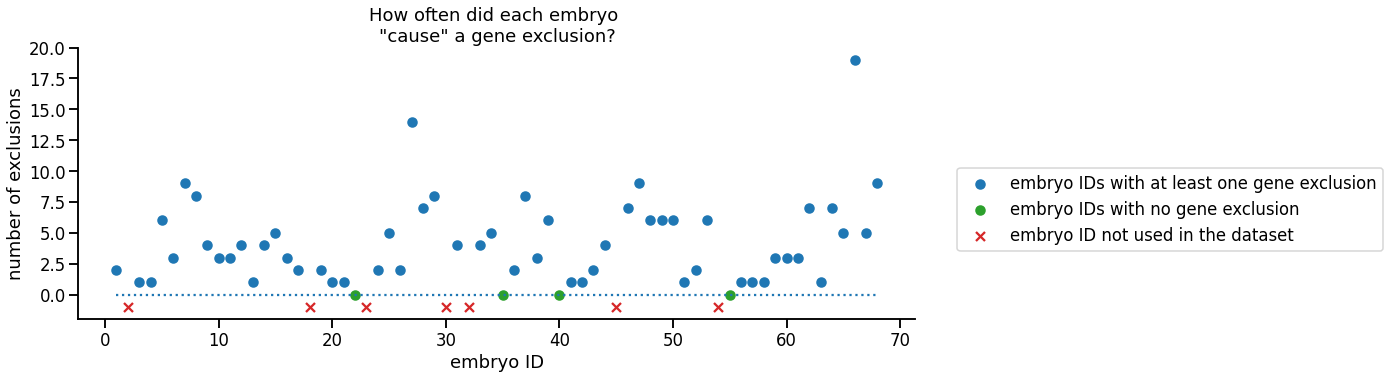

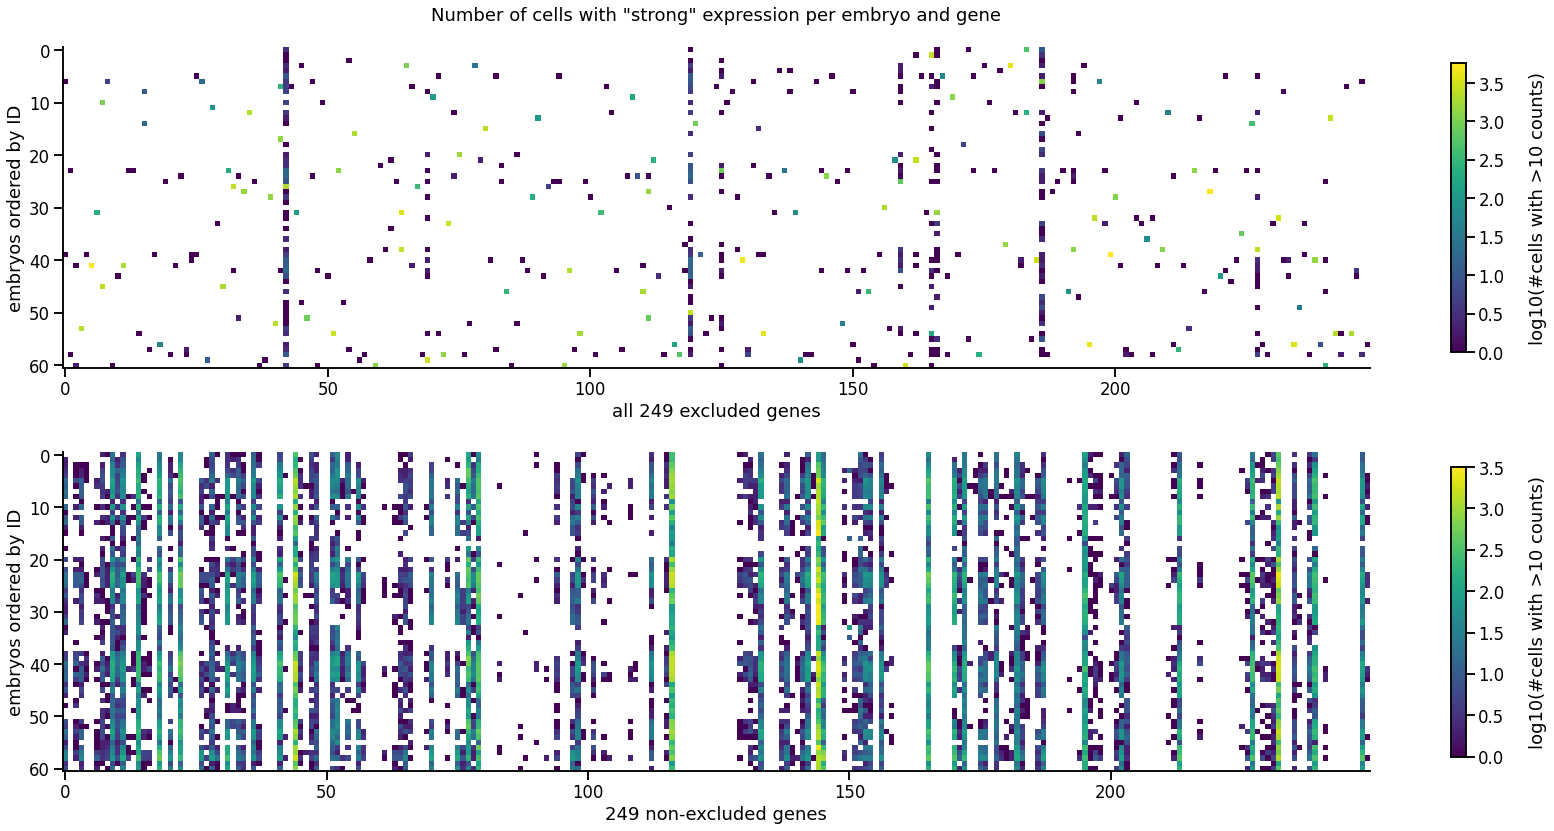

In [11]:
with open('datasets/cao/artifact_genes.pickle','rb') as f:
    genes_to_remove = pickle.load(f)
genes_to_remove_idx = np.isin(adata_hvg_pearson.var['genes'], genes_to_remove)

with sns.plotting_context('talk'):

    ##how often is each embryo "causing" a gene exclusion
    embryos_causing_exclusion_idx = np.argmax(n_cells_with_mincount[:,genes_to_remove_idx],axis=0)
    embryo_ids_causing_exclusion = embryo_ids[embryos_causing_exclusion_idx]
    exclusions_per_embryo = []
    ##count exclusions
    for e in embryo_ids:
        exclusions_per_embryo.append(sum(e==embryo_ids_causing_exclusion))
    exclusions_per_embryo = np.array(exclusions_per_embryo)
    ##account for embryo IDs that are never used
    missing_embryo_ids = np.array([e for e in range(1,max(embryo_ids)+1) if e not in embryo_ids])

    plt.figure(figsize=(15,5))
    plt.scatter(embryo_ids[exclusions_per_embryo>0],exclusions_per_embryo[exclusions_per_embryo>0],label='embryo IDs with at least one gene exclusion')
    plt.scatter(embryo_ids[exclusions_per_embryo==0],exclusions_per_embryo[exclusions_per_embryo==0],c="tab:green",label='embryo IDs with no gene exclusion')

    plt.scatter(missing_embryo_ids,np.ones(missing_embryo_ids.shape)*-1,marker='x',c="tab:red",label='embryo ID not used in the dataset')

    plt.ylim(-2,20)
    plt.title('How often did each embryo \n"cause" a gene exclusion?')
    plt.ylabel('number of exclusions')
    plt.xlabel('embryo ID')
    plt.hlines(0,min(embryo_ids),max(embryo_ids),linestyles=':')
    plt.legend(loc=(1.05,0.25))
    sns.despine()
    

with sns.plotting_context('talk'):

    plt.figure(figsize=(12*2,6*2))
    plt.subplot(211)
    plt.imshow(np.log10(n_cells_with_mincount[:,genes_to_remove_idx]))
    plt.xlabel('all 249 excluded genes')
    plt.ylabel('embryos ordered by ID')
    plt.title('Number of cells with "strong" expression per embryo and gene\n')
    plt.colorbar(shrink=0.8,label='\nlog10(#cells with >10 counts)')

    plt.subplot(212)
    plt.imshow(np.log10(n_cells_with_mincount[:,~genes_to_remove_idx][:,:250]))
    plt.xlabel('249 non-excluded genes')
    plt.ylabel('embryos ordered by ID')
    plt.colorbar(shrink=0.8,label='\nlog10(#cells with >10 counts)')
    
    sns.despine()
    plt.tight_layout()
    

- all embryos are affected sometimes (i.e., are the only embryo that expresses a gene much stronger than the other embryos)

- non-excluded genes are either strong in many embroyos (often in all) -- or in none

## Figure S6

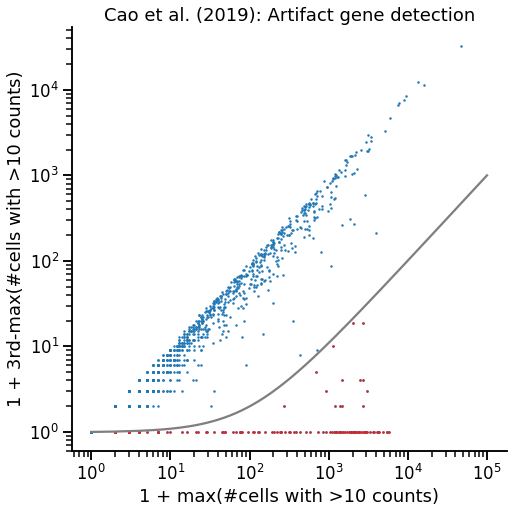

In [12]:
with sns.plotting_context('talk'):
    scale=1.3

    pdata = plotdata_figS6
       
    plt.figure(figsize=(6*scale,6*scale))
    ax = plt.gca()
    
    ax.set_title('Cao et al. (2019): Artifact gene detection')

    
    ax.scatter(1+pdata['n_cells_with_mincount_max'],1+pdata['n_cells_with_mincount_3rdmax'],s=1,rasterized=True)
    ax.scatter(1+pdata['n_cells_with_mincount_max'][pdata['genes_to_remove_idx']],1+pdata['n_cells_with_mincount_3rdmax'][pdata['genes_to_remove_idx']],s=1,c="tab:red", rasterized=True)
    x = np.arange(0,10**5,1)
    ax.plot(1+x,1+x/pdata['cutoff_factor'],label='threshold x/%s'%pdata['cutoff_factor'],color='tab:gray')        

    ax.set_xlabel('1 + max(#cells with >%u counts)'%(pdata['mincount']))
    ax.set_ylabel('1 + 3rd-max(#cells with >%u counts)'%(pdata['mincount']))
    ax.set_yscale('log')
    ax.set_xscale('log')

    sns.despine()
    plt.savefig('FigS6.pdf', dpi=300, format=None)

In [13]:
### remove artifact genes
with open('datasets/cao/artifact_genes.pickle','rb') as f:
    genes_to_remove = pickle.load(f)

genes_to_keep_idx = ~np.isin(adata_hvg_pearson.var['genes'],genes_to_remove)
adata_hvg_pearson_batchcorrected = adata_hvg_pearson[:,genes_to_keep_idx].copy()

## Compute PCA / GLM-PCA

In [14]:
def scale_pca_output(X):
    return X / np.max(np.abs(X))

def get_pca_init_for_tSNE(X):
    return X[:,:2] / np.std(X[:,0]) * .0001

def logmedian_PCA(adata,tag='',n_PCs = 50, seed=42):
    mediannorm =  sc.pp.normalize_total(adata,inplace=False)['X'] ## median normalization by default
    logmedian = sc.pp.log1p(mediannorm)
    logmedian_pca = sc.pp.pca(logmedian,random_state=seed,n_comps=n_PCs)
    with open('datasets/cao/logmedian_PCA%s.pickle' % (tag),'wb') as f:
        pickle.dump(logmedian_pca,f)
        
def logmedian_scaled_PCA(adata,tag='',n_PCs = 50, seed=42):
    mediannorm =  sc.pp.normalize_total(adata,inplace=False)['X'] ## median normalization by default
    logmedian = sc.pp.log1p(mediannorm)
    logmedian_scaled = sc.pp.scale(logmedian) #scales to zero mean and unit variance
    logmedian_scaled_pca = sc.pp.pca(logmedian_scaled,random_state=seed,n_comps=n_PCs)
    with open('datasets/cao/logmedian_scaled_PCA%s.pickle' % (tag),'wb') as f:
        pickle.dump(logmedian_scaled_pca,f)
        
def pearson_residuals_PCA(adata,theta=100,tag='',n_PCs = 50, seed=42):
    residuals = pearson_residuals(adata.X.toarray(),theta)
    pearson_PCA = sc.pp.pca(residuals,random_state=seed,n_comps=n_PCs)
    with open('datasets/cao/pearson_PCA%s.pickle' % (tag),'wb') as f:
        pickle.dump(pearson_PCA,f)

In [15]:
### THIS CELL CAN BE COMMENTED OUT AFTER IT RAN ONCE ###
%time logmedian_PCA(adata_hvg_pearson)
%time logmedian_scaled_PCA(adata_hvg_pearson)
%time pearson_residuals_PCA(adata_hvg_pearson)
%time pearson_residuals_PCA(adata_hvg_pearson_batchcorrected,tag='_batchcorrected')

In [16]:
### THIS CELL CAN BE COMMENTED OUT AFTER IT RAN ONCE ###
### Monitor progress in glmpca_progress textfile ###
batch_size = 10000
tag = 'caodata_batchsize%u' % batch_size
with open('glmpca_progress_%s.txt'%tag, 'w') as f:        
    with redirect_stderr(f):
        glmpca_R(adata_hvg_pearson.X,fam='nb',label=tag, batch_size=batch_size)

#### Load results

In [17]:
## Original Pearson residual gene selection
with open('datasets/cao/logmedian_PCA.pickle','rb') as f:
    logmedian_PCA_raw = pickle.load(f)
    adata_hvg_pearson.obsm['logmedian_PCA'] = scale_pca_output(logmedian_PCA_raw)
    adata_hvg_pearson.obsm['shared_init'] = get_pca_init_for_tSNE(logmedian_PCA_raw)
    
with open('datasets/cao/logmedian_scaled_PCA.pickle','rb') as f:
    adata_hvg_pearson.obsm['logmedian_scaled_PCA'] = scale_pca_output(pickle.load(f))
    
with open('datasets/cao/pearson_PCA.pickle','rb') as f:
    adata_hvg_pearson.obsm['pearson_PCA'] = scale_pca_output(pickle.load(f))

with open('glmpca_results/glmpcacaodata_batchsize10000_nb_tol0.0001_results.pickle','rb') as f:
    glmpca_dict_batch10k = pickle.load(f)        
    adata_hvg_pearson.obsm['glmpca_batchsize10k'] = scale_pca_output(glmpca_dict_batch10k['factors'])
    
## After removal of batch artifact genes
with open('datasets/cao/pearson_PCA_batchcorrected.pickle','rb') as f:
    adata_hvg_pearson_batchcorrected.obsm['pearson_PCA'] = scale_pca_output(pickle.load(f))

#### Value of fitted `theta` for GLM-PCA

In [18]:
glmpca_dict_batch10k['nb_theta']

0.5574220696140907

## Compute tSNEs

In [19]:
tag = 'caodata'

In [21]:
# ### THIS CELL CAN BE COMMENTED OUT AFTER IT RAN ONCE ###
_ = kobak_tsne_w_exag(adata_hvg_pearson.obsm['logmedian_PCA'],              name='%s_pcaLogmedian_sharedInit' % tag,                 exag=4,do_pca=False,init=adata_hvg_pearson.obsm['shared_init'])
_ = kobak_tsne_w_exag(adata_hvg_pearson.obsm['logmedian_scaled_PCA'],       name='%s_pcaLogmedianScaled_sharedInit' % tag,           exag=4,do_pca=False,init=adata_hvg_pearson.obsm['shared_init'])
_ = kobak_tsne_w_exag(adata_hvg_pearson.obsm['pearson_PCA'],                name='%s_pcaPearson_sharedInit' % tag,                   exag=4,do_pca=False,init=adata_hvg_pearson.obsm['shared_init'])
_ = kobak_tsne_w_exag(adata_hvg_pearson.obsm['glmpca_batchsize10k'], name='%s_glmpcaBatchsize10k_sharedInit' % tag,    exag=4,do_pca=False,init=adata_hvg_pearson.obsm['shared_init'])
_ = kobak_tsne_w_exag(adata_hvg_pearson_batchcorrected.obsm['pearson_PCA'], name='%s_batchcorrected_pcaPearson_sharedInit' % tag,    exag=4,do_pca=False,init=adata_hvg_pearson.obsm['shared_init'])

In [22]:
with open('tsne/tsne_%s_pcaLogmedian_sharedInit.pickle'%tag,'rb') as f:
    adata_hvg_pearson.obsm['pca_logmedian_tsne'] = pickle.load(f)['coords']
    
with open('tsne/tsne_%s_pcaLogmedianScaled_sharedInit.pickle'%tag,'rb') as f:
    adata_hvg_pearson.obsm['pca_logmedian_scaled_tsne'] = pickle.load(f)['coords']
    
with open('tsne/tsne_%s_pcaPearson_sharedInit.pickle'%tag,'rb') as f:
    adata_hvg_pearson.obsm['pca_pearson_tsne'] = pickle.load(f)['coords']    
    
with open('tsne/tsne_%s_glmpcaBatchsize10k_sharedInit.pickle'%tag,'rb') as f:
    adata_hvg_pearson.obsm['glmpca_batchsize10k_tsne'] = pickle.load(f)['coords']    
    
with open('tsne/tsne_%s_batchcorrected_pcaPearson_sharedInit.pickle'%tag,'rb') as f:
    adata_hvg_pearson_batchcorrected.obsm['pca_pearson_tsne'] = pickle.load(f)['coords']

## Figure 4

In [47]:
trajText =       ['Endothelial',         'Hepatocyte',    'HAEMATOPOIESIS', 'NEURAL CREST', 'NEURAL TUBE',     'Epithelial',      'Lens',         'MESENCHYMAL']
trajTextCoords = [dict(x=-15,y=19.5), dict(x=-12.5,y=23.5), dict(x=5,y=13),  dict(x=10,y=8), dict(x=10,y=-5), dict(x=1,y=4.7),   dict(x=2,y=1.4), dict(x=-11.5,y=0)]

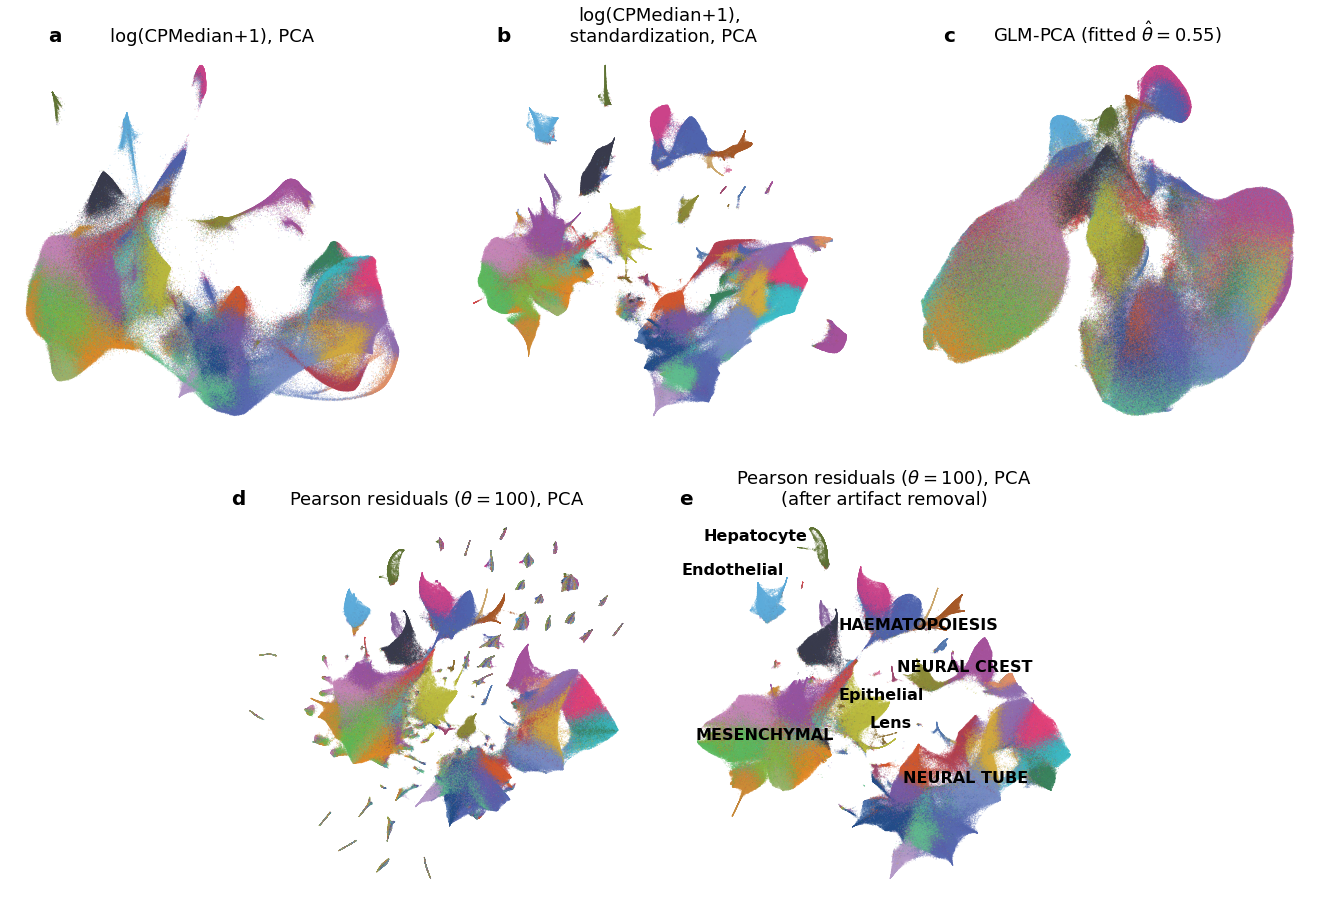

In [49]:
title_fontsize = 20
title_fontweight = "bold"

letters = ['a','b','c', 'd', 'e']

#random permutation for plotting
np.random.seed(42)
rnd_idx = np.random.permutation(sum(clusters>=0))


with sns.plotting_context('talk'):

    tsnes = [adata_hvg_pearson.obsm['pca_logmedian_tsne'],
             adata_hvg_pearson.obsm['pca_logmedian_scaled_tsne'],
             adata_hvg_pearson.obsm['glmpca_batchsize10k_tsne'],
             adata_hvg_pearson.obsm['pca_pearson_tsne'],
             adata_hvg_pearson_batchcorrected.obsm['pca_pearson_tsne'],]
    titles = ['log(CPMedian+1), PCA',
              'log(CPMedian+1),\n standardization, PCA',
              r'GLM-PCA (fitted $\hat\theta=0.55$)',
              r'Pearson residuals ($\theta=100$), PCA',
              r'Pearson residuals ($\theta=100$), PCA'+'\n(after artifact removal)',]
    
    scale=1.3
    plt.figure(figsize=(18*scale,12*scale))

    ax1 = plt.subplot2grid(shape=(2,6), loc=(0, 0), colspan=2)
    ax2 = plt.subplot2grid(shape=(2,6), loc=(0, 2), colspan=2)
    ax3 = plt.subplot2grid(shape=(2,6), loc=(0, 4), colspan=2)
    ax4 = plt.subplot2grid(shape=(2,6), loc=(1, 1), colspan=2)
    ax5 = plt.subplot2grid(shape=(2,6), loc=(1, 3), colspan=2)

    axes = [ax1,ax2,ax3,ax4,ax5]
    
    for i,(ax,title,tsne,letter) in enumerate(zip(axes,titles,tsnes,letters)):
        
        ax.set_title(title)
        titleletter_loc = (0.1,1.015) if i in [0,1,2] else (0,1.015)
        ax.text(*titleletter_loc,letters[i],transform=ax.transAxes,fontsize=title_fontsize,fontweight=title_fontweight)        

        ax.scatter(*tsne[clusters>=0][rnd_idx].T,c=clusterColors[clusters[clusters>=0]][rnd_idx],s=1,edgecolor='none',alpha=0.3,rasterized=True)
        ax.axis('off')


        sns.despine()
        
        if i==4:

            for t in range(len(trajText)):
                ax.text(**trajTextCoords[t], s=trajText[t],fontsize=16,ha='center', va='center',fontweight='bold')
               
    plt.savefig('Fig4.pdf', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)
    plt.show()

In [24]:
%load_ext watermark

In [25]:
watermark --iversions

anndata   : 0.7.5
pandas    : 1.2.0
matplotlib: 3.3.3
scanpy    : 1.7.1
numpy     : 1.20.1
scipy     : 1.6.0
seaborn   : 0.11.1



In [26]:
watermark

Last updated: 2021-07-31T19:47:47.111670+02:00

Python implementation: CPython
Python version       : 3.8.0
IPython version      : 7.21.0

Compiler    : GCC 8.3.0
OS          : Linux
Release     : 3.10.0-957.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit

